# CS 180 Group 4: 

## Determining the Housing and Water Expenditure Based on Household-Level Data

### Introduction

The project aims to develop a regression model that can predict housing and water expenditure based on user information. The group's objective is to assist Filipino households in their financial management and provide future household heads with estimates of costs related to housing, water, and electricity, thereby aiding them in their family or house plans.

### Data Exploration

#### Preliminaries

##### Import libraries

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

##### Import Dataset

In [2]:
df_dataset = pd.read_csv('Family Income and Expenditure.csv')

#### Pre-processing

##### Checking the data structure

###### 
Generate Pandas Profiling

In [3]:
import pandas_profiling as pp

*Uncomment the lines below to generate a new profile report.*

In [4]:
# report = pp.ProfileReport(df_dataset)
# report.to_file('profile_report.html')

Refer to the detailed profile report, with the filename of 'profile_report.html', was pre-generated using the same code above.

###### 
Examine structure

In [5]:
df_dataset.describe()

,Total Household Income,Total Food Expenditure,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
count,4.154400e+04,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,...,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000,41544.000000
mean,2.475556e+05,85099.158194,0.429858,25133.723642,18195.825005,10540.072574,10529.318337,2550.474990,5006.918568,15436.566075,...,0.394184,0.319806,0.129814,0.081215,0.060610,1.905738,0.315015,0.135038,0.013119,0.289885
std,2.868805e+05,51637.947682,0.676666,13466.482984,11727.224350,10497.727757,7812.201613,2969.752879,3300.175236,23705.195929,...,0.537025,0.478482,0.448673,0.346786,0.276732,1.558130,0.739698,0.354083,0.127171,0.558408
min,1.128500e+04,2947.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.048950e+05,51017.250000,0.000000,16556.000000,11020.000000,3353.750000,5504.000000,1024.750000,2873.000000,1930.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.640795e+05,72985.500000,0.000000,23324.000000,16620.000000,7332.500000,8695.000000,1820.000000,4314.000000,7314.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,2.911385e+05,105635.500000,1.000000,31439.000000,23920.000000,14292.000000,13388.000000,3100.000000,6304.250000,19921.250000,...,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
max,1.181599e+07,827565.000000,2.000000,765864.000000,758326.000000,261566.000000,188208.000000,273769.000000,74800.000000,725296.000000,...,5.000000,3.000000,5.000000,5.000000,4.000000,10.000000,6.000000,3.000000,3.000000,5.000000


###### 
Correlation Matrix

C:\Users\roelf\AppData\Local\Temp\ipykernel_41660\667580603.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df_dataset.corr()


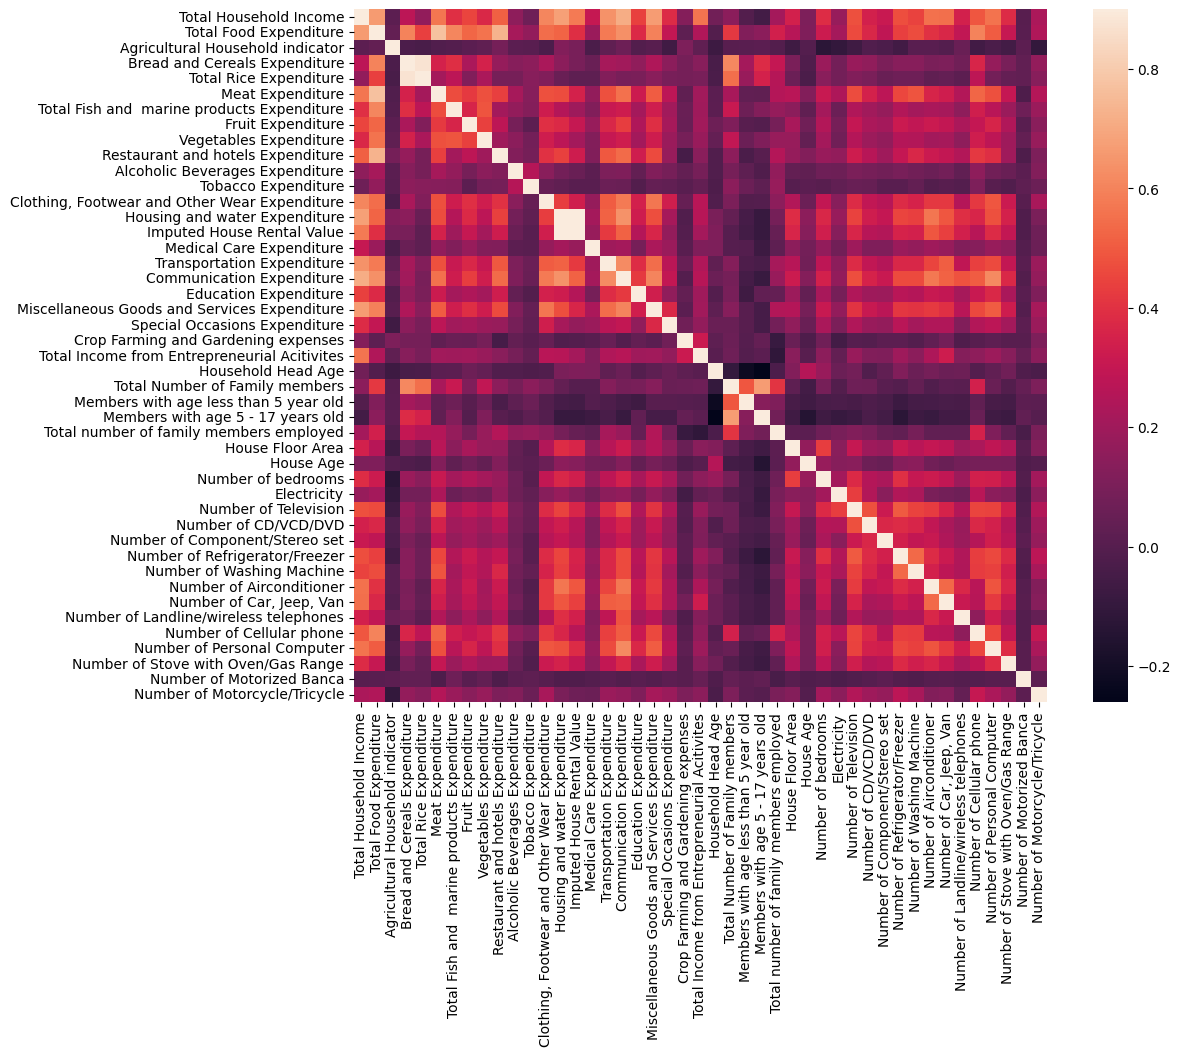

In [6]:
corrmat = df_dataset.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True)
plt.show()

###### 
Correlation with House and Water Expenditure

C:\Users\roelf\AppData\Local\Temp\ipykernel_41660\2943646804.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df_dataset.corr()


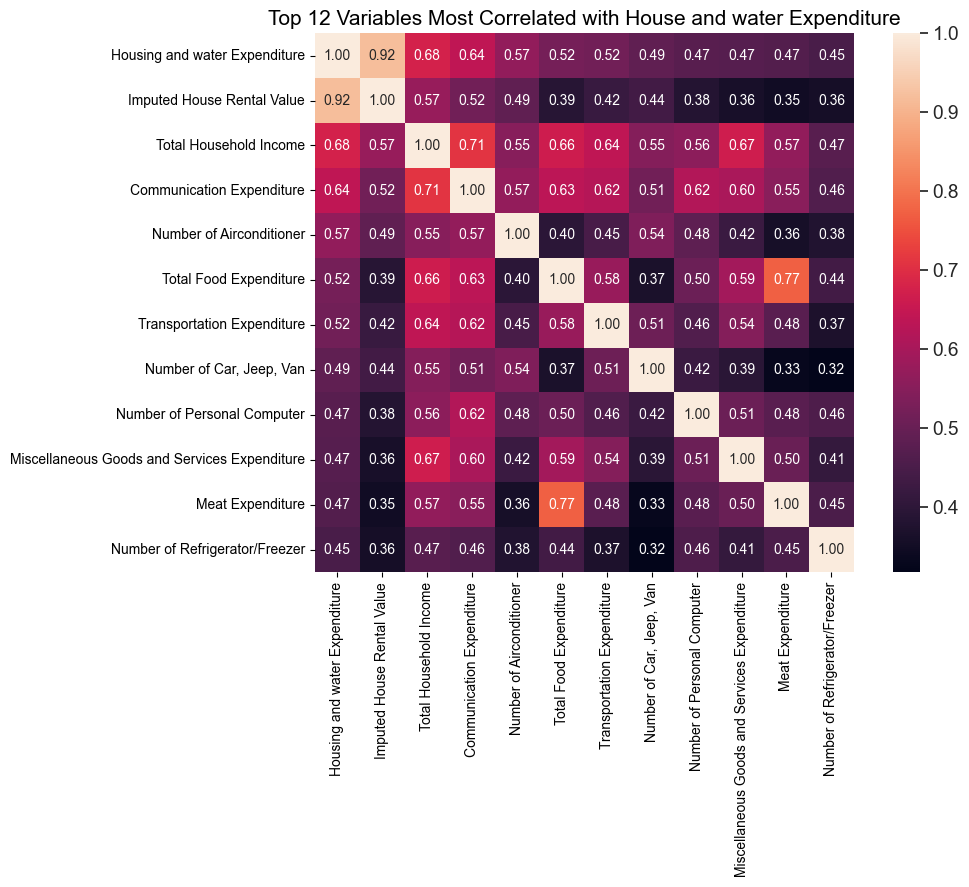

In [7]:
target = 'Housing and water Expenditure'
k = 12
corrmat = df_dataset.corr()
cols = corrmat.nlargest(k, target)[target].index
f, ax = plt.subplots(figsize=(10, 7))
cm = np.corrcoef(df_dataset[cols].values.T)
sns.set(font_scale=1.25)


s = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
s.set_title("Top 12 Variables Most Correlated with House and water Expenditure", size=15)
plt.show()

### Methodology

#### I. Initialization

We start the project by importing the necessary libraries and modules. Additionally, we load the FIES (Filipino Income and Expenditure) dataset and clean it by utilizing only the initially identified features and dropping rows with null values.

Dataset source: https://www.kaggle.com/datasets/grosvenpaul/family-income-and-expenditure

Furthermore, we merge the features 'Members with age less than 5 years old' and 'Members with age 5 - 17 years old' to create the 'Number of Children' feature.

In [8]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector

# Load the dataset
df_dataset = pd.read_csv('Family Income and Expenditure.csv')

# Initial features to use
features = [
    "Housing and water Expenditure",
    "Total Household Income",
    "Region",
    "Agricultural Household indicator",
    "Imputed House Rental Value",
    "Total Income from Entrepreneurial Acitivites",
    "Total Number of Family members",
    "Members with age less than 5 year old",
    "Members with age 5 - 17 years old",
    "Total number of family members employed",
    "Type of Building/House",
    "Type of Roof",
    "Type of Walls",
    "House Floor Area",
    "House Age",
    "Number of bedrooms",
    "Electricity",
    "Main Source of Water Supply",
    "Number of Television",
    "Number of CD/VCD/DVD",
    "Number of Component/Stereo set",
    "Number of Refrigerator/Freezer",
    "Number of Washing Machine",
    "Number of Airconditioner",
    "Number of Personal Computer"
]

# Drop features that are not in the initial set of features
df = df_dataset.filter(features, axis=1)

# To clean the dataset:
# Drop rows with missing values
df.dropna(inplace=True)

# Create feature called "Number of Children"
df['Number of Children'] = df['Members with age less than 5 year old'] + df['Members with age 5 - 17 years old']

# Drop combined features
df = df.drop(['Members with age less than 5 year old', 'Members with age 5 - 17 years old'], axis=1)

#### II. Feature Selection

Next, we will identify the list of unique categories for three categorical features: Region, Type of Building/House, and Main Source of Water Supply. Note that this step is necessary since, as we will see later, these three features are included in the final Regression Model.

In [9]:
# Identify unique values for each of the three categorical feature included in the final regression model

# list region names
region_names = list(df['Region'].unique())
print(f'Regions: {region_names}')
print()
# output: ['CAR', 'Caraga', 'VI - Western Visayas', 'V - Bicol Region', ' ARMM', 'III - Central Luzon', 'II - Cagayan Valley', 'IVA - CALABARZON', 'VII - Central Visayas', 'X - Northern Mindanao', 'XI - Davao Region', 'VIII - Eastern Visayas', 'I - Ilocos Region', 'NCR', 'IVB - MIMAROPA', 'XII - SOCCSKSARGEN', 'IX - Zasmboanga Peninsula']

# list type of building/house
house_types = list(df['Type of Building/House'].unique())
print(f'Type of Building/House: {house_types}')
print()
# output : ['Single house', 'Duplex', 'Commercial/industrial/agricultural building', 'Multi-unit residential', 'Institutional living quarter', 'Other building unit (e.g. cave, boat)']

# list main source of water supply
water_sources = list(df['Main Source of Water Supply'].unique())
print(f'Main Source of Water Supply: {water_sources}') 
print()
# output : ['Own use, faucet, community water system', 'Shared, faucet, community water system', 'Shared, tubed/piped deep well', 'Own use, tubed/piped deep well', 'Protected spring, river, stream, etc', 'Tubed/piped shallow well', 'Lake, river, rain and others', 'Unprotected spring, river, stream, etc', 'Dug well', 'Others', 'Peddler']

Regions: ['CAR', 'Caraga', 'VI - Western Visayas', 'V - Bicol Region', ' ARMM', 'III - Central Luzon', 'II - Cagayan Valley', 'IVA - CALABARZON', 'VII - Central Visayas', 'X - Northern Mindanao', 'XI - Davao Region', 'VIII - Eastern Visayas', 'I - Ilocos Region', 'NCR', 'IVB - MIMAROPA', 'XII - SOCCSKSARGEN', 'IX - Zasmboanga Peninsula']

Type of Building/House: ['Single house', 'Duplex', 'Commercial/industrial/agricultural building', 'Multi-unit residential', 'Institutional living quarter', 'Other building unit (e.g. cave, boat)']

Main Source of Water Supply: ['Own use, faucet, community water system', 'Shared, faucet, community water system', 'Shared, tubed/piped deep well', 'Own use, tubed/piped deep well', 'Protected spring, river, stream, etc', 'Tubed/piped shallow well', 'Lake, river, rain and others', 'Unprotected spring, river, stream, etc', 'Dug well', 'Others', 'Peddler']



Upon inspection, we can see two typographical errors. These errors are the ' ARMM' and 'IX - Zasmboanga Peninsula' categories of the Region feature. We will correct them using the code below.

In [10]:
# Correct typos in region names
df['Region'] = df['Region'].replace(' ARMM', 'ARMM')
df['Region'] = df['Region'].replace('IX - Zasmboanga Peninsula', 'IX - Zamboanga Peninsula')

# Update region names
region_names = list(df['Region'].unique())
print(region_names)

['CAR', 'Caraga', 'VI - Western Visayas', 'V - Bicol Region', 'ARMM', 'III - Central Luzon', 'II - Cagayan Valley', 'IVA - CALABARZON', 'VII - Central Visayas', 'X - Northern Mindanao', 'XI - Davao Region', 'VIII - Eastern Visayas', 'I - Ilocos Region', 'NCR', 'IVB - MIMAROPA', 'XII - SOCCSKSARGEN', 'IX - Zamboanga Peninsula']


As seen above, the typographical errors have now been collected.

Since we have categorical variables, we use target encoding to convert categorical values into numerical ones. We also store the encoding map for later use.

In [11]:
# Define the categorical columns
cat_cols = ['Region', 'Type of Building/House', 'Type of Roof', 'Type of Walls', 'Main Source of Water Supply']

# Create an instance of the TargetEncoder from the category_encoders library
# The purpose of the TargetEncoder is to transform categorical features into numeric representations
encoder = ce.TargetEncoder(cols=cat_cols)

# Fit and transform the target encoder on the dataframe
df_encoded = encoder.fit_transform(df, df['Housing and water Expenditure'])

# Access the mapping
mapping = encoder.mapping

# Replace the original categorical columns with the target-encoded values
df[cat_cols] = df_encoded[cat_cols]

# Create a dictionary mapping the categorical columns to the target encoding
cat_dict_map = {}
for column in cat_cols:
    cat_dict_map[column] = list(mapping[column])[:-2]

From the encoding map, we create dictionaries for converting the categorical features included in the final regression model. To avoid confusion, we note that these features are identified by the feature selection method, which will be performed later on. Essentially, we added these codes to this part because we already know that they will be used.

In [12]:
# Create a dictionary mapping the categorical columns to the target encoding

convert_region = {k: v for k, v in zip(region_names, cat_dict_map['Region'])}
convert_house_type = {k: v for k, v in zip(house_types, cat_dict_map['Type of Building/House'])}
convert_water_source = {k: v for k, v in zip(water_sources, cat_dict_map['Main Source of Water Supply'])}

Now, we are ready to begin building our regression model. We start by separating the features from the target, which is 'Housing and Water Expenditure'. Then, we determine highly correlated features and drop them. However, we can see that the initial features are not highly correlated. Thus, no features are dropped at this stage.

Link to source code:
https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

In [13]:
# Split the dataframe into X and y
X = df.drop(['Housing and water Expenditure'], axis=1)
y = df['Housing and water Expenditure']

# Analyze the correlation among the features
threshold = 0.9
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
upper.head()

# Drop columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

if len(to_drop) > 0:
    print(f'Columns to drop: {to_drop}')
    X = X.drop(to_drop, axis=1)
else:
    print('No columns to drop. The features are not highly correlated.')
    

No columns to drop. The features are not highly correlated.


#### III. Training and Testing

Next, we determine the best features to use in the regression model. We split our data for training and testing. Additionally, we observe that a linear regression model was used for sequential feature selection. This is because it is the simplest regression model, and feature selection requires a significant amount of computation power and time. We drop the features that are not selected.

To do this, we will be using the class sklearn.feature_selection.SequentialFeatureSelector from the scikit-learn library that implements a sequential feature selection algorithm. This module adds or removes (in our case, we will be looking at removing features)  to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

More about this here:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

In [14]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Forward feature selection
regressor = LinearRegression()
sfs = SequentialFeatureSelector(regressor, k_features='best', forward=True, scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_train, y_train)

selected_features = list(X_train.columns[list(sfs.k_feature_idx_)])
print(f'Selected Features: {selected_features}')

# Drop features that are not selected
to_drop = [feature for feature in X.columns if feature not in selected_features]
X = X.drop(to_drop, axis=1)
print(f'Dropped features: {to_drop}')

Selected Features: ['Total Household Income', 'Region', 'Imputed House Rental Value', 'Total Number of Family members', 'Type of Building/House', 'House Floor Area', 'House Age', 'Number of bedrooms', 'Main Source of Water Supply', 'Number of CD/VCD/DVD', 'Number of Component/Stereo set', 'Number of Refrigerator/Freezer', 'Number of Washing Machine', 'Number of Airconditioner', 'Number of Personal Computer']
Dropped features: ['Agricultural Household indicator', 'Total Income from Entrepreneurial Acitivites', 'Total number of family members employed', 'Type of Roof', 'Type of Walls', 'Electricity', 'Number of Television', 'Number of Children']


#### IV. Choosing Machine Learning Model To Use

Initially, we decided to use a Linear Regression Model since it was discussed and presented clearly by our course adviser. However, we decided to test the Linear Regression Model against other models and comparing their metrics.

##### Linear Regression

MSE: 281265826.2560366
RMSE: 16770.981672401784
MAE: 7470.806807253993
R2: 0.9004809121373123


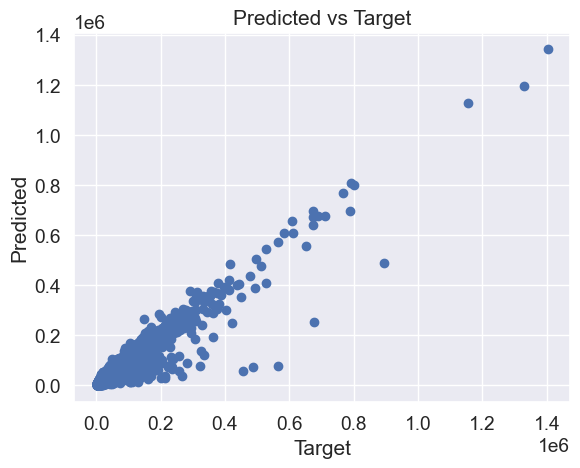

In [15]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test_linear = train_test_split(X, y, test_size=0.30, random_state=1)

# Forward feature selection
regressor = LinearRegression()
sfs = SequentialFeatureSelector(regressor, k_features='best', forward=True, scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_train, y_train)

selected_features = list(X_train.columns[list(sfs.k_feature_idx_)])

# Drop features that are not selected
to_drop = [feature for feature in X.columns if feature not in selected_features]
X = X.drop(to_drop, axis=1)

# Fit the model and predict the target
regressor.fit(X_train, y_train)
linear_pred = regressor.predict(X_test)

# Calculate the metrics
MSE_linear = mean_squared_error(y_test_linear, linear_pred)
RMSE_linear = np.sqrt(mean_squared_error(y_test_linear, linear_pred))
MAE_linear = mean_absolute_error(y_test_linear, linear_pred)
R2_linear = r2_score(y_test_linear, linear_pred)

# Show and plot the metrics and the results
print(f'MSE: {MSE_linear}')
print(f'RMSE: {RMSE_linear}')
print(f'MAE: {MAE_linear}')
print(f'R2: {R2_linear}')

plt.scatter(y_test_linear, linear_pred)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()

##### Ridge

Best Alpha: 0.1
MSE: 281265837.04847443
RMSE: 16770.98199416106
MAE: 7470.805712746491
R2: 0.90048090831867


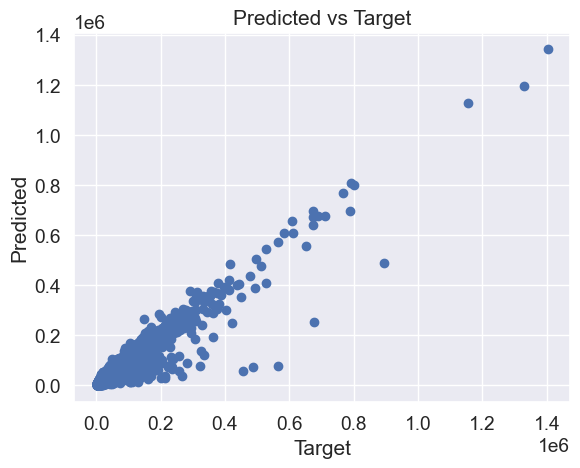

In [16]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test_ridge = train_test_split(X, y, test_size=0.30, random_state=1)

ridge_cv = RidgeCV(cv=5)  # 5-fold cross-validation
ridge_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_cv.alpha_

ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

print(f'Best Alpha: {best_alpha_ridge}')

# Calculate the metrics
MSE_ridge = mean_squared_error(y_test_ridge, ridge_pred)
RMSE_ridge = np.sqrt(mean_squared_error(y_test_ridge, ridge_pred))
MAE_ridge = mean_absolute_error(y_test_ridge, ridge_pred)
R2_ridge = r2_score(y_test_ridge, ridge_pred)

# Show and plot the metrics and the results
print(f'MSE: {MSE_ridge}')
print(f'RMSE: {RMSE_ridge}')
print(f'MAE: {MAE_ridge}')
print(f'R2: {R2_ridge}')

plt.scatter(y_test_ridge, ridge_pred)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()

##### Lasso

Best Alpha: 0.1
MSE: 308853715.48688203
RMSE: 17574.234421074565
MAE: 7929.189259377773
R2: 0.8907196069376847


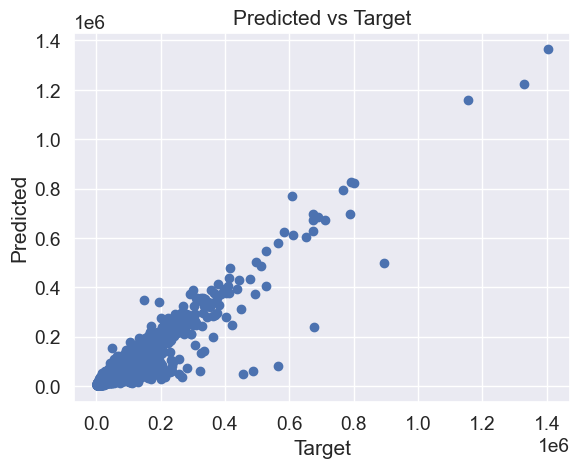

In [17]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test_lasso = train_test_split(X, y, test_size=0.30, random_state=1)

lasso_cv = LassoCV(cv=5)  # 5-fold cross-validation
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.alpha_

lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

print(f'Best Alpha: {best_alpha_ridge}')

# Calculate the metrics
MSE_lasso = mean_squared_error(y_test_lasso, lasso_pred)
RMSE_lasso = np.sqrt(mean_squared_error(y_test_lasso, lasso_pred))
MAE_lasso = mean_absolute_error(y_test_lasso, lasso_pred)
R2_lasso = r2_score(y_test_lasso, lasso_pred)

# Show and plot the metrics and the results
print(f'MSE: {MSE_lasso}')
print(f'RMSE: {RMSE_lasso}')
print(f'MAE: {MAE_lasso}')
print(f'R2: {R2_lasso}')

plt.scatter(y_test_lasso, lasso_pred)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()

##### Polynomial Regression

MSE: 272514064.47355986
RMSE: 16508.000014343343
MAE: 7088.7856923732525
R2: 0.9035775106874353


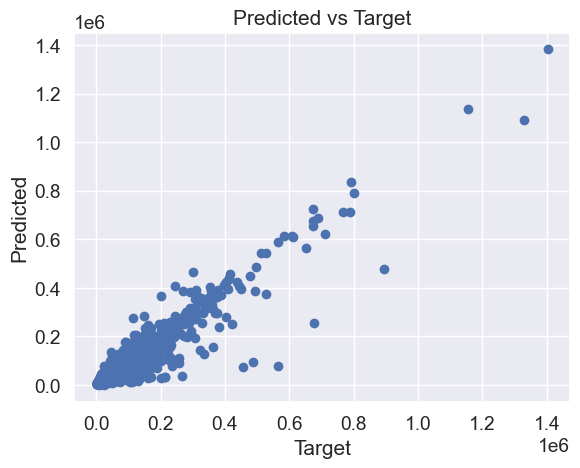

In [18]:
# Account for the interaction between features using a polynomial of degree 2
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X)

# Split the data into train and test sets using X_interactions instead of X
X_train, X_test, y_train, y_test_poly = train_test_split(X_interactions, y, test_size=0.30, random_state=1)

# Fit the model and predict the target
regressor.fit(X_train, y_train)
poly_pred = regressor.predict(X_test)

# Calculate the metrics
MSE_poly = mean_squared_error(y_test_poly, poly_pred)
RMSE_poly = np.sqrt(mean_squared_error(y_test_poly, poly_pred))
MAE_poly = mean_absolute_error(y_test_poly, poly_pred)
R2_poly = r2_score(y_test_poly, poly_pred)

# Show and plot the metrics and the results
print(f'MSE: {MSE_poly}')
print(f'RMSE: {RMSE_poly}')
print(f'MAE: {MAE_poly}')
print(f'R2: {R2_poly}')

plt.scatter(y_test_poly, poly_pred)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()

##### Neural Network Model

This Neural Network model uses all of the columns as opposed to selected features to take advantage of the properties of neural networks and the amount of data.

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt
import category_encoders as ce
import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras.layers import Dense

# Load the dataset
df_dataset = pd.read_csv('Family Income and Expenditure.csv')

# Identify the list of unique categories for the categorical features
region = list(df_dataset['Region'].unique())
main_source_of_income = list(df_dataset['Main Source of Income'].unique())
household_head_sex = list(df_dataset['Household Head Sex'].unique())
household_head_marital_status = list(df_dataset['Household Head Marital Status'].unique())
household_head_highest_grade_completed = list(df_dataset['Household Head Highest Grade Completed'].unique())
household_head_job_or_business_indicator = list(df_dataset['Household Head Job or Business Indicator'].unique())
household_head_occupation = list(df_dataset['Household Head Occupation'].unique())
household_head_class_of_worker = list(df_dataset['Household Head Class of Worker'].unique())
type_of_household = list(df_dataset['Type of Household'].unique())
type_of_buildingHouse = list(df_dataset['Type of Building/House'].unique())
type_of_roof = list(df_dataset['Type of Roof'].unique())
type_of_walls = list(df_dataset['Type of Walls'].unique())
tenure_status = list(df_dataset['Tenure Status'].unique())
toilet_facilities = list(df_dataset['Toilet Facilities'].unique())
main_source_of_water_supply = list(df_dataset['Main Source of Water Supply'].unique())

# correct typos in region names
df_dataset['Region'] = df_dataset['Region'].replace(' ARMM', 'ARMM')
df_dataset['Region'] = df_dataset['Region'].replace('IX - Zasmboanga Peninsula', 'IX - Zamboanga Peninsula')

# update region names
region = list(df_dataset['Region'].unique())

# Define the categorical columns
cat_cols = ['Region', 'Main Source of Income', 'Household Head Sex', 'Household Head Marital Status', 'Household Head Highest Grade Completed', 'Household Head Job or Business Indicator', 'Household Head Occupation', 'Household Head Class of Worker', 'Type of Household', 'Type of Building/House', 'Type of Roof', 'Type of Walls', 'Tenure Status', 'Toilet Facilities', 'Main Source of Water Supply', ]

# Create an instance of the TargetEncoder
encoder = ce.TargetEncoder(cols=cat_cols)

# Fit and transform the target encoder on the dataframe
df_encoded = encoder.fit_transform(df_dataset, df_dataset['Housing and water Expenditure'])

# Access the mapping
mapping = encoder.mapping

# Replace the original categorical columns with the target-encoded values
df_dataset[cat_cols] = df_encoded[cat_cols]

# Create a dictionary mapping the categorical columns to the target encoding
cat_dict_map = {}
for column in cat_cols:
    cat_dict_map[column] = list(mapping[column])[:-2]

convert_region = {k: v for k, v in zip(region, cat_dict_map['Region'])}
convert_main_source_of_income = {k: v for k, v in zip(main_source_of_income, cat_dict_map['Main Source of Income'])}
convert_household_head_sex = {k: v for k, v in zip(household_head_sex, cat_dict_map['Household Head Sex'])}
convert_household_head_marital_status = {k: v for k, v in zip(household_head_marital_status, cat_dict_map['Household Head Marital Status'])}
convert_household_head_highest_grade_completed = {k: v for k, v in zip(household_head_highest_grade_completed, cat_dict_map['Household Head Highest Grade Completed'])}
convert_household_head_job_or_business_indicator = {k: v for k, v in zip(household_head_job_or_business_indicator, cat_dict_map['Household Head Job or Business Indicator'])}
convert_household_head_occupation = {k: v for k, v in zip(household_head_occupation, cat_dict_map['Household Head Occupation'])}
convert_household_head_class_of_worker = {k: v for k, v in zip(household_head_class_of_worker, cat_dict_map['Household Head Class of Worker'])}
convert_type_of_household = {k: v for k, v in zip(type_of_household, cat_dict_map['Type of Household'])}
convert_type_of_buildingHouse = {k: v for k, v in zip(type_of_buildingHouse, cat_dict_map['Type of Building/House'])}
convert_type_of_roof = {k: v for k, v in zip(type_of_roof, cat_dict_map['Type of Roof'])}
convert_type_of_walls = {k: v for k, v in zip(type_of_walls, cat_dict_map['Type of Walls'])}
convert_tenure_status = {k: v for k, v in zip(tenure_status, cat_dict_map['Tenure Status'])}
convert_toilet_facilities = {k: v for k, v in zip(toilet_facilities, cat_dict_map['Toilet Facilities'])}
convert_main_source_of_water_supply = {k: v for k, v in zip(main_source_of_water_supply, cat_dict_map['Main Source of Water Supply'])}

# columns = ['Housing and water Expenditure', 'Total Household Income', 'Region', 'Imputed House Rental Value', 'Total Number of Family members', 'Type of Building/House', 'House Floor Area', 'House Age', 'Number of bedrooms', 'Main Source of Water Supply', 'Number of CD/VCD/DVD', 'Number of Component/Stereo set', 'Number of Refrigerator/Freezer', 'Number of Washing Machine', 'Number of Airconditioner', 'Number of Personal Computer']
# df_dataset = df_dataset.filter(columns, axis=1)

# Split into input (X) and output (y) variables
X = df_dataset.drop(['Housing and water Expenditure'], axis=1)
y = df_dataset['Housing and water Expenditure']

X_train, X_temp, Y_train, Y_temp = train_test_split(X, y, test_size = 0.3, random_state=2)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size = 0.5, random_state=2)

# define the keras model
model = Sequential()
model.add(Dense(12, input_shape=(59,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# compile the keras model
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

*Uncomment the lines below to retrain the neural network model.*

In [20]:
# # Fit the keras model on the dataset
# model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=1000)

Since training the dataset takes a lot of time, a pre-trained model will be saved to save time.<br>
*Uncomment the lines below to retrain the neural network model.*<br>
***Do not save unless the model has been retrained***

In [21]:
# # Save the Neural Network model into a file
# model.save("model_NeuralNetwork.keras")

Finally, we assess the metrics, such as Mean Square Error (MSE), Root Mean Square Error (RMSE), Mean Absolute Error (MAE). We can see that the Neural Network model has a relatively low MAE and a relatively low RMSE, indicating that it performs well in predicting the target. Note that although the RMSE is in the thousands, its unit is the Philippine Peso.

195/195 [==============================] - 0s 1ms/step
MSE: 215029712.0
RMSE: 14663.8916015625
MAE: 6443.54931640625


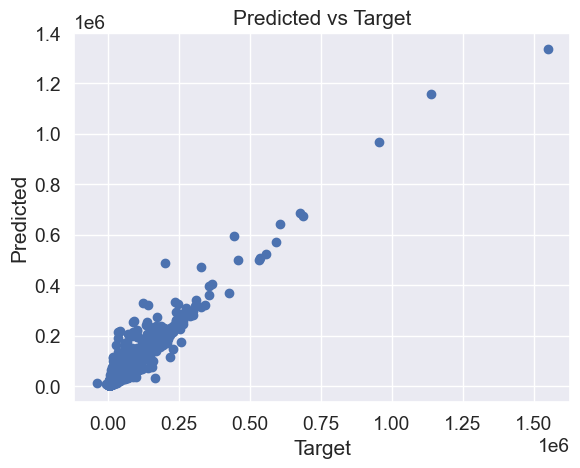

In [22]:
# Load the Neural Network model from a file
loaded = loaded_model = tf.keras.saving.load_model("model_NeuralNetwork.keras")

# Evaluating the Neural Network model
_, MSE_neural, RMSE_neural, MAE_neural = loaded.evaluate(X_test, Y_test)

Y_pred = loaded.predict(X_test)

# Show and plot the metrics and the results
print(f'MSE: {MSE_neural}')
print(f'RMSE: {RMSE_neural}')
print(f'MAE: {MAE_neural}')

# Plot Predicted vs Target
plt.scatter(Y_pred, Y_test)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()

##### Comparing the Metrics of the Models

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,281265826.2560365796,16770.9816724018,7470.8068072540,0.9004809121
1,Ridge,281265837.0484744310,16770.9819941611,7470.8057127465,0.9004809083
2,Lasso,308853715.4868820310,17574.2344210746,7929.1892593778,0.8907196069
3,Polynomial Regression,272514064.4735598564,16508.0000143433,7088.7856923733,0.9035775107
4,Neural Network,215029712.0000000000,14663.8916015625,6443.5493164062,


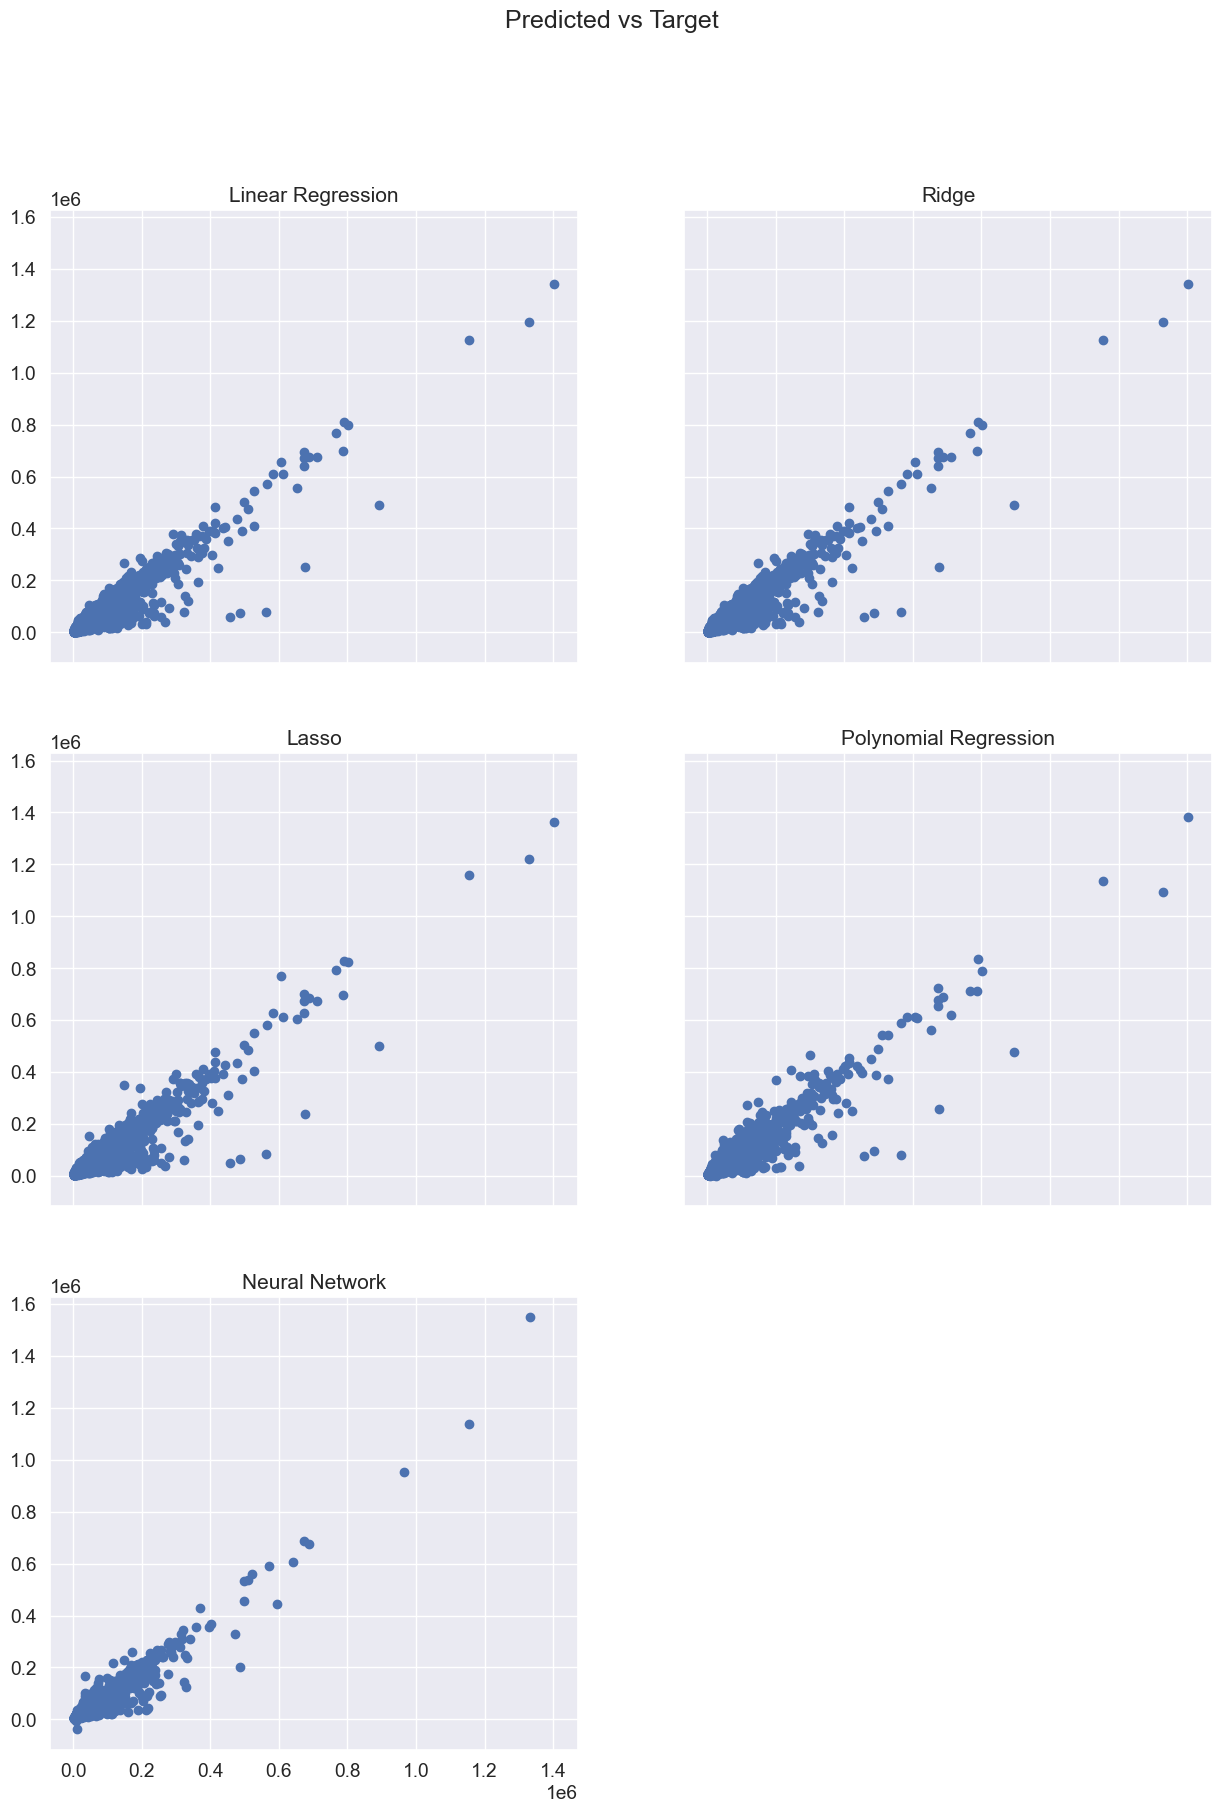

In [23]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(15, 20))
fig.suptitle('Predicted vs Target')

ax1.set_title('Linear Regression')
ax1.scatter(y_test_linear, linear_pred)

ax2.set_title('Ridge')
ax2.scatter(y_test_ridge, ridge_pred)

ax3.set_title('Lasso')
ax3.scatter(y_test_lasso, lasso_pred)

ax4.set_title('Polynomial Regression')
ax4.scatter(y_test_poly, poly_pred)

ax5.set_title('Neural Network')
ax5.scatter(Y_test, Y_pred)

ax6.axis('off')

for ax in fig.get_axes():
    ax.label_outer()


metrics = {
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Polynomial Regression', 'Neural Network'],
    'MSE': [MSE_linear, MSE_ridge, MSE_lasso, MSE_poly, MSE_neural],
    'RMSE': [RMSE_linear, RMSE_ridge, RMSE_lasso, RMSE_poly, RMSE_neural],
    'MAE': [MAE_linear, MAE_ridge, MAE_lasso, MAE_poly, MAE_neural],
    'R2': [R2_linear, R2_ridge, R2_lasso, R2_poly, ""]
    }

df_metrics = pd.DataFrame(data=metrics)
pd.set_option('display.float_format', '{:.10f}'.format)
df.style \
  .format(precision=9)
df_metrics


Based on the metrics and graph presented, it can be observed that the Neural Network Model exhibits superior performance. However, it should be noted that neural networks, or deep learning models heavily relies on data, necessitating a substantial volume of data to effectively learn the underlying structure and parameters. We believe that the dataset used in this study may not be of sufficient size to establish the reliability of the Neural Network Model. Moreover, neural networks have a tendency to overfit, compromising their predictive capabilities for future instances.

In the end, we decided to use the Polynomial Regression Model (2nd Degree). Firstly, this is because Regression Analysis is less of a black box and is easier to communicate.
Two important factors we considered when we chose a model are how simple the model is and how interpretable it is. A simpler model means it’s easier to communicate how the model itself works and how to interpret the results of a model. And based on the metrics and the graph, the Polynomial Regression Model outperforms the other models except the Neural Network Model.

#### V. Polynomial Regression Model 2nd Degree

Now, we take into account the interactions between the features. Particualarly, we model these interactions as a second-degree polynomial. Apart from saving computational resources, using this degree yields the best results compared to using higher degrees. This can be explained by factors such as overfitting. We also split the data again for the training and testing of our Polynomial Regression model. It is also important to note that it now uses X_interactions, which account for the feature interactions, instead of the original data X.

In [25]:
# Polynomial Regression
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X)

# Split the data into train and test sets using X_interactions instead of X
X_train, X_test, y_train, y_test = train_test_split(X_interactions, y, test_size=0.30, random_state=1)

# Fit the model and predict the target
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

Finally, we assess the metrics, such as RMSE and R2. We can see that our Polynomial Regression model has an R2 close to 1 and a relatively low RMSE, indicating that it performs well in predicting the target. Note that although the RMSE is in the thousands, its unit is the Philippine Peso.

RMSE: 18043.172978161765
R2: 0.884809876593759


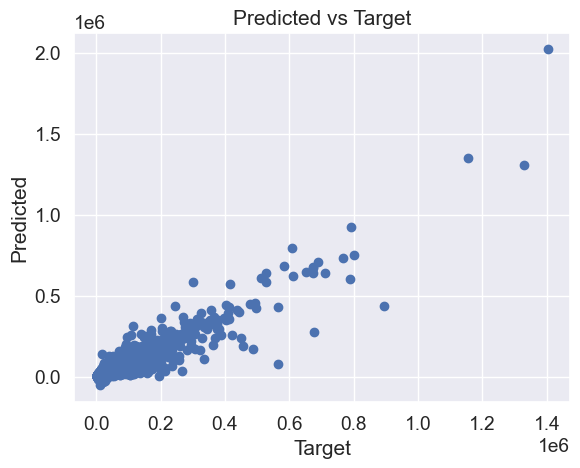

In [26]:
# Show and plot the results
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2: {r2_score(y_test, y_pred)}')

plt.scatter(y_test, y_pred)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()

#### VI. Creating a Web App For the Practical Use of the Model

Using Flask, we now make a locally-hosted Web App that predicts the Housing and Water expenditures.

In [27]:
# Create a function to predict the Housing and Water expenditure given an array of user inputs
def model_predict(input_arr):
    encoded_input = [input_arr]

    # Encode categorical variables
    for i in range(len(input_arr)):
        if i == 1:
            encoded_input[0][i] = convert_region[input_arr[i]]
        elif i == 4:
            encoded_input[0][i] = convert_house_type[input_arr[i]]
        elif i == 8:
            encoded_input[0][i] = convert_water_source[input_arr[i]] 

    # Perform polynomial feature transformation if applicable
    input_interactions = poly.fit_transform(encoded_input)

    # Make prediction
    prediction = regressor.predict(input_interactions)

    # Return prediction
    return float(prediction[0])

In [28]:
# Import libraries
from flask import Flask, render_template, request, jsonify

# Change based on Saved location
path = r'C:\Users\roelf\Downloads\SCHOOL\3rd Year\2nd Semester\CS 180\Project\Income\github\CS180-Project'

app = Flask(__name__, static_folder = path)

@app.route('/')
def index():
    return render_template('index.html')

# Flask route handler
@app.route('/calculate', methods=['POST'])
def calculate():
    features = [key for key in request.form.keys() if key.startswith('input')]
    input_arr = [request.form.get(key) for key in features]
    conv_input = [float(input_arr[i]) if i not in (1,4,8) else input_arr[i] for i in range(len(input_arr))]
    result = 'Php'+str(round(model_predict(conv_input), 2))
    return jsonify(result=result)

if __name__ == '__main__':
    app.run(host='0.0.0.0')

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.254.102:5000
Press CTRL+C to quit
